## 1. Setup & Import Libraries

In [26]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.style.use('default')
plt.rcParams['figure.dpi'] = 100

In [27]:
def plot_frequency_distribution(df, numerical_cols=None, categorical_cols=None, cols_per_row=3):
    if numerical_cols is None:
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    if categorical_cols is None:
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    total_features = len(numerical_cols) + len(categorical_cols)
    n_rows = (total_features + cols_per_row - 1) // cols_per_row
    
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(18, 5*n_rows))
    axes = axes.flatten() if total_features > 1 else [axes]
    fig.suptitle('FREQUENCY DISTRIBUTION ANALYSIS', fontsize=16, fontweight='bold', y=0.995)
    
    plot_idx = 0
    
    for col in numerical_cols:
        ax = axes[plot_idx]
        counts, bins, patches = ax.hist(df[col], bins=30, edgecolor='black', color='steelblue', alpha=0.7, density=True)
        ax.set_title(f'{col.capitalize()} (Numerical)', fontweight='bold', fontsize=11)
        ax.set_xlabel(col)
        ax.set_ylabel('Normalized Frequency 0 to 1')
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim([0, 1])
        skewness = skew(df[col].dropna())
        ax.text(0.98, 0.97, f'Skew: {skewness:.2f}', transform=ax.transAxes,
                ha='right', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
        plot_idx += 1
    
    for col in categorical_cols:
        ax = axes[plot_idx]
        value_counts = df[col].value_counts()
        normalized_counts = value_counts / value_counts.sum()
        colors_palette = plt.cm.Set3(np.linspace(0, 1, len(value_counts)))
        ax.bar(range(len(value_counts)), normalized_counts.values, color=colors_palette, edgecolor='black', alpha=0.7)
        ax.set_xticks(range(len(value_counts)))
        ax.set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=9)
        ax.set_title(f'{col.capitalize()} (Categorical)', fontweight='bold', fontsize=11)
        ax.set_ylabel('Normalized Frequency 0 to 1')
        ax.set_ylim([0, 1])
        ax.grid(axis='y', alpha=0.3)
        for i, v in enumerate(normalized_counts.values):
            ax.text(i, v, f'{v*100:.1f}%', ha='center', va='bottom', fontsize=8)
        plot_idx += 1
    
    for idx in range(plot_idx, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()


def plot_histograms(df, columns=None, cols_per_row=3, bins=30):
    if columns is None:
        columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    n_features = len(columns)
    n_rows = (n_features + cols_per_row - 1) // cols_per_row
    
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(6*cols_per_row, 4*n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]
    fig.suptitle('HISTOGRAM ANALYSIS', fontsize=16, fontweight='bold')
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_features))
    
    for idx, col in enumerate(columns):
        ax = axes[idx]
        ax.hist(df[col].dropna(), bins=bins, color=colors[idx], edgecolor='black', alpha=0.7)
        ax.set_title(f'{col.capitalize()}', fontweight='bold')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.grid(axis='y', alpha=0.3)
        
        mean_val = df[col].mean()
        median_val = df[col].median()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
        ax.legend(fontsize=8)
    
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()


def plot_pie_charts(df, columns=None, cols_per_row=3):
    if columns is None:
        columns = df.select_dtypes(include=['object']).columns.tolist()
    
    n_features = len(columns)
    n_rows = (n_features + cols_per_row - 1) // cols_per_row
    
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(6*cols_per_row, 5*n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]
    fig.suptitle('PIE CHART ANALYSIS', fontsize=16, fontweight='bold')
    
    for idx, col in enumerate(columns):
        ax = axes[idx]
        value_counts = df[col].value_counts()
        
        if len(value_counts) > 8:
            top_values = value_counts.head(7)
            other_sum = value_counts.iloc[7:].sum()
            top_values['Other'] = other_sum
            value_counts = top_values
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(value_counts)))
        wedges, texts, autotexts = ax.pie(
            value_counts.values, 
            labels=value_counts.index,
            autopct='%1.1f%%',
            colors=colors,
            startangle=90,
            pctdistance=0.75
        )
        ax.set_title(f'{col.capitalize()}', fontweight='bold', fontsize=12)
        
        for autotext in autotexts:
            autotext.set_fontsize(8)
        for text in texts:
            text.set_fontsize(8)
    
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()


def plot_scatter_matrix(df, columns=None, target_col=None, figsize=(14, 14)):
    if columns is None:
        columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()[:6]  # Limit to 6
    
    n = len(columns)
    fig, axes = plt.subplots(n, n, figsize=figsize)
    fig.suptitle('SCATTER MATRIX ANALYSIS', fontsize=16, fontweight='bold', y=1.02)
    
    colors = plt.cm.tab10(np.linspace(0, 1, 2)) if target_col else ['steelblue']
    
    for i, col_y in enumerate(columns):
        for j, col_x in enumerate(columns):
            ax = axes[i, j]
            
            if i == j:
                ax.hist(df[col_x].dropna(), bins=20, color='steelblue', edgecolor='black', alpha=0.7)
            else:
                if target_col and target_col in df.columns:
                    for k, target_val in enumerate(df[target_col].unique()[:2]):
                        mask = df[target_col] == target_val
                        ax.scatter(df.loc[mask, col_x], df.loc[mask, col_y], 
                                  alpha=0.3, s=5, c=[colors[k]], label=f'{target_val}')
                else:
                    ax.scatter(df[col_x], df[col_y], alpha=0.3, s=5, c='steelblue')
            
            if i == n - 1:
                ax.set_xlabel(col_x, fontsize=9)
            if j == 0:
                ax.set_ylabel(col_y, fontsize=9)
            
            ax.tick_params(labelsize=7)
    
    plt.tight_layout()
    plt.show()


def plot_scatter_pairs(df, x_cols, y_cols, target_col=None, cols_per_row=3):
    n_plots = len(x_cols)
    n_rows = (n_plots + cols_per_row - 1) // cols_per_row
    
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(6*cols_per_row, 5*n_rows))
    axes = axes.flatten() if n_plots > 1 else [axes]
    fig.suptitle('SCATTER PLOT ANALYSIS', fontsize=16, fontweight='bold')
    
    colors = plt.cm.Set1(np.linspace(0, 1, 2))
    
    for idx, (x_col, y_col) in enumerate(zip(x_cols, y_cols)):
        ax = axes[idx]
        
        if target_col and target_col in df.columns:
            for k, target_val in enumerate(df[target_col].unique()[:2]):
                mask = df[target_col] == target_val
                ax.scatter(df.loc[mask, x_col], df.loc[mask, y_col], 
                          alpha=0.5, s=20, c=[colors[k]], label=f'{target_col}={target_val}', edgecolors='white', linewidth=0.5)
            ax.legend(fontsize=8)
        else:
            ax.scatter(df[x_col], df[y_col], alpha=0.5, s=20, c='steelblue', edgecolors='white', linewidth=0.5)
        
        ax.set_xlabel(x_col, fontweight='bold')
        ax.set_ylabel(y_col, fontweight='bold')
        ax.set_title(f'{x_col} vs {y_col}', fontweight='bold')
        ax.grid(alpha=0.3)
    
    for idx in range(n_plots, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()


def plot_feature_scaling(X_before, X_after, features, title='Feature Scaling'):
    n_features = len(features)
    fig, axes = plt.subplots(2, n_features, figsize=(6*n_features, 8))
    fig.suptitle(title, fontsize=14, fontweight='bold')
    
    for idx, col in enumerate(features):
        axes[0, idx].hist(X_before[col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
        axes[0, idx].set_title(f'{col.capitalize()} - Before Scaling', fontweight='bold')
        axes[0, idx].set_ylabel('Frequency')
        axes[0, idx].grid(axis='y')
        
        axes[1, idx].hist(X_after[col], bins=30, color='coral', edgecolor='black', alpha=0.7)
        axes[1, idx].set_title(f'{col.capitalize()} - After Scaling', fontweight='bold')
        axes[1, idx].set_ylabel('Frequency')
        axes[1, idx].grid(axis='y')
    
    plt.tight_layout()
    plt.show()


def plot_target_distribution(df_encoded, y_train, y_test, target_col='income'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Target/Predict Variable Distribution', fontsize=14, fontweight='bold')
    
    income_counts = df_encoded[target_col].value_counts()
    axes[0].bar(['≤50K', '>50K'], [income_counts[0], income_counts[1]], 
                color=['#ff9999', '#66b3ff'], edgecolor='black', alpha=0.7)
    axes[0].set_title('Full Dataset', fontweight='bold')
    axes[0].set_ylabel('Count')
    axes[0].grid(axis='y')
    for i, v in enumerate([income_counts[0], income_counts[1]]):
        axes[0].text(i, v, f'{v}', ha='center', va='bottom', fontweight='bold')
    
    train_income = y_train.value_counts()
    test_income = y_test.value_counts()
    x = np.arange(2)
    width = 0.35
    axes[1].bar(x - width/2, [train_income[0], train_income[1]], width, label='Train', color='steelblue', alpha=0.7)
    axes[1].bar(x + width/2, [test_income[0], test_income[1]], width, label='Test', color='coral', alpha=0.7)
    axes[1].set_title('Train vs Test Split', fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(['≤50K', '>50K'])
    axes[1].set_ylabel('Count')
    axes[1].legend()
    axes[1].grid(axis='y')
    
    plt.tight_layout()
    plt.show()


def plot_correlation_heatmap(df, numerical_cols=None, figsize=(12, 10)):
    if numerical_cols is None:
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    correlation_matrix = df[numerical_cols].corr()
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Correlation', fontsize=12)
    
    ax.set_xticks(np.arange(len(numerical_cols)))
    ax.set_yticks(np.arange(len(numerical_cols)))
    ax.set_xticklabels(numerical_cols, rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(numerical_cols, fontsize=10)
    
    for i in range(len(numerical_cols)):
        for j in range(len(numerical_cols)):
            value = correlation_matrix.iloc[i, j]
            text_color = 'white' if abs(value) > 0.5 else 'black'
            ax.text(j, i, f'{value:.2f}', ha='center', va='center', 
                   color=text_color, fontsize=9, fontweight='bold')
    
    ax.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_missing_values(df, figsize=(14, 6)):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({'Count': missing, 'Percentage': missing_pct})
    missing_df = missing_df[missing_df['Count'] > 0].sort_values('Count', ascending=False)
    
    if len(missing_df) == 0:
        print("No missing values found in the dataset!")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Missing Values Analysis', fontsize=14, fontweight='bold')
    
    axes[0].barh(missing_df.index, missing_df['Count'], color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].set_title('Missing Values Count', fontweight='bold')
    axes[0].set_xlabel('Count')
    axes[0].grid(axis='x', alpha=0.3)
    
    axes[1].barh(missing_df.index, missing_df['Percentage'], color='coral', edgecolor='black', alpha=0.7)
    axes[1].set_title('Missing Values Percentage', fontweight='bold')
    axes[1].set_xlabel('Percentage (%)')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_boxplots(df, numerical_cols=None, cols_per_row=3):
    if numerical_cols is None:
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    n_features = len(numerical_cols)
    n_rows = (n_features + cols_per_row - 1) // cols_per_row
    
    fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(6*cols_per_row, 4*n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]
    fig.suptitle('Boxplot Analysis for Outlier Detection', fontsize=14, fontweight='bold')
    
    for idx, col in enumerate(numerical_cols):
        axes[idx].boxplot(df[col].dropna(), patch_artist=True,
                         boxprops=dict(facecolor='steelblue', alpha=0.7))
        axes[idx].set_title(f'{col.capitalize()}', fontweight='bold')
        axes[idx].grid(axis='y', alpha=0.3)
    
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()


def plot_all_variants(df, col, target_col=None):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'ALL VISUALIZATIONS FOR: {col.upper()}', fontsize=16, fontweight='bold')
    
    if df[col].dtype in ['int64', 'float64']:
        axes[0].hist(df[col].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
        mean_val = df[col].mean()
        axes[0].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        axes[0].legend()
    else:
        value_counts = df[col].value_counts()
        colors = plt.cm.Set3(np.linspace(0, 1, len(value_counts)))
        axes[0].bar(range(len(value_counts)), value_counts.values, color=colors, edgecolor='black', alpha=0.7)
        axes[0].set_xticks(range(len(value_counts)))
        axes[0].set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=8)
    axes[0].set_title(f'{col} - Histogram/Bar', fontweight='bold')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(axis='y', alpha=0.3)
    
    if df[col].dtype == 'object' or df[col].nunique() <= 10:
        value_counts = df[col].value_counts()
        if len(value_counts) > 8:
            top_values = value_counts.head(7)
            top_values['Other'] = value_counts.iloc[7:].sum()
            value_counts = top_values
        colors = plt.cm.Set3(np.linspace(0, 1, len(value_counts)))
        axes[1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', 
                   colors=colors, startangle=90)
    else:
        bins = pd.cut(df[col], bins=5)
        value_counts = bins.value_counts().sort_index()
        colors = plt.cm.Set3(np.linspace(0, 1, len(value_counts)))
        axes[1].pie(value_counts.values, labels=[str(x) for x in value_counts.index], 
                   autopct='%1.1f%%', colors=colors, startangle=90)
    axes[1].set_title(f'{col} - Pie Chart', fontweight='bold')
    
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    other_col = [c for c in numerical_cols if c != col]
    
    if df[col].dtype in ['int64', 'float64'] and len(other_col) > 0:
        y_col = other_col[0]
        if target_col and target_col in df.columns:
            colors_scatter = plt.cm.Set1(np.linspace(0, 1, 2))
            for k, target_val in enumerate(df[target_col].unique()[:2]):
                mask = df[target_col] == target_val
                axes[2].scatter(df.loc[mask, col], df.loc[mask, y_col], 
                              alpha=0.3, s=10, c=[colors_scatter[k]], label=f'{target_val}')
            axes[2].legend()
        else:
            axes[2].scatter(df[col], df[y_col], alpha=0.3, s=10, c='steelblue')
        axes[2].set_xlabel(col)
        axes[2].set_ylabel(y_col)
    else:
        axes[2].scatter(range(len(df)), df[col] if df[col].dtype in ['int64', 'float64'] 
                       else df[col].astype('category').cat.codes, alpha=0.3, s=10, c='steelblue')
        axes[2].set_xlabel('Index')
        axes[2].set_ylabel(col)
    axes[2].set_title(f'{col} - Scatter', fontweight='bold')
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [28]:
def plot_histogram(df, columns=None, cols_per_row=3, bins=30, show_stats=True, 
                   density=False, figsize=None, title=None, color='steelblue'):
    if columns is None:
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        columns = numerical_cols + categorical_cols
    
    n_features = len(columns)
    
    if n_features == 0:
        print("No columns to plot!")
        return None, None
    
    n_rows = (n_features + cols_per_row - 1) // cols_per_row
    n_cols = min(cols_per_row, n_features)
    
    if figsize is None:
        figsize = (6 * n_cols, 4 * n_rows)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    if n_features == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()
    
    fig.suptitle(title or 'HISTOGRAM ANALYSIS', fontsize=16, fontweight='bold', y=1.002)
    
    for idx, col in enumerate(columns):
        ax = axes[idx]
        is_numerical = df[col].dtype in ['int64', 'float64']
        
        if is_numerical:
            ax.hist(df[col].dropna(), bins=bins, color=color, edgecolor='black', 
                   alpha=0.7, density=density)
            
            if show_stats:
                mean_val = df[col].mean()
                median_val = df[col].median()
                std_val = df[col].std()
                skewness = skew(df[col].dropna())
                
                ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                          label=f'Mean: {mean_val:.2f}')
                ax.axvline(median_val, color='green', linestyle='-.', linewidth=2, 
                          label=f'Median: {median_val:.2f}')
                
                stats_text = f'Skew: {skewness:.2f}\nStd: {std_val:.2f}'
                ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, ha='right', va='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=9)
                ax.legend(fontsize=8, loc='upper right')
            
            ax.set_xlabel(col, fontsize=10)
        else:
            value_counts = df[col].value_counts()
            colors = plt.cm.Set3(np.linspace(0, 1, len(value_counts)))
            
            bars = ax.bar(range(len(value_counts)), value_counts.values, 
                         color=colors, edgecolor='black', alpha=0.7)
            ax.set_xticks(range(len(value_counts)))
            ax.set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=8)
            
            for i, v in enumerate(value_counts.values):
                ax.text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=7)
        
        ax.set_title(f'{col.upper()}', fontweight='bold', fontsize=11)
        ax.set_ylabel('Density' if density else 'Frequency')
        ax.grid(axis='y', alpha=0.3)
    
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes

In [29]:
def plot_bar_chart(df, columns=None, cols_per_row=3, orientation='vertical', 
                   show_values=True, show_percentage=False, top_n=None,
                   figsize=None, title=None, color_palette='Set3'):
    if columns is None:
        columns = df.select_dtypes(include=['object']).columns.tolist()
        for col in df.select_dtypes(include=['int64', 'float64']).columns:
            if df[col].nunique() <= 15:
                columns.append(col)
    
    n_features = len(columns)
    
    if n_features == 0:
        print("No columns to plot!")
        return None, None
    
    n_rows = (n_features + cols_per_row - 1) // cols_per_row
    n_cols = min(cols_per_row, n_features)
    
    if figsize is None:
        if orientation == 'horizontal':
            figsize = (6 * n_cols, 5 * n_rows)
        else:
            figsize = (6 * n_cols, 4 * n_rows)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    if n_features == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()
    
    fig.suptitle(title or 'BAR CHART ANALYSIS', fontsize=16, fontweight='bold', y=1.002)
    
    for idx, col in enumerate(columns):
        ax = axes[idx]
        
        value_counts = df[col].value_counts()
        
        if top_n and len(value_counts) > top_n:
            value_counts = value_counts.head(top_n)
        
        if show_percentage:
            total = df[col].value_counts().sum()
            display_values = (value_counts / total * 100).round(1)
            value_label = '%'
        else:
            display_values = value_counts
            value_label = ''
        
        cmap = plt.cm.get_cmap(color_palette)
        colors = [cmap(i / len(value_counts)) for i in range(len(value_counts))]
        
        if orientation == 'horizontal':
            bars = ax.barh(range(len(value_counts)), display_values.values, 
                          color=colors, edgecolor='black', alpha=0.7)
            ax.set_yticks(range(len(value_counts)))
            ax.set_yticklabels(value_counts.index, fontsize=9)
            ax.set_xlabel('Percentage (%)' if show_percentage else 'Count')
            ax.invert_yaxis()  
            
            if show_values:
                for i, (bar, v) in enumerate(zip(bars, display_values.values)):
                    ax.text(v + max(display_values) * 0.01, bar.get_y() + bar.get_height()/2,
                           f'{v:,.1f}{value_label}' if show_percentage else f'{int(v):,}',
                           ha='left', va='center', fontsize=8)
        else:
            bars = ax.bar(range(len(value_counts)), display_values.values, 
                         color=colors, edgecolor='black', alpha=0.7)
            ax.set_xticks(range(len(value_counts)))
            ax.set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=8)
            ax.set_ylabel('Percentage (%)' if show_percentage else 'Count')
            
            if show_values:
                for i, (bar, v) in enumerate(zip(bars, display_values.values)):
                    ax.text(bar.get_x() + bar.get_width()/2, v,
                           f'{v:.1f}{value_label}' if show_percentage else f'{int(v):,}',
                           ha='center', va='bottom', fontsize=7)
        
        ax.set_title(f'{col.upper()}', fontweight='bold', fontsize=11)
        ax.grid(axis='x' if orientation == 'horizontal' else 'y', alpha=0.3)
    
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes

In [30]:
def plot_frequency_polygon(df, columns=None, cols_per_row=3, bins=30, 
                           show_histogram=False, density=False, show_stats=True,
                           figsize=None, title=None, linewidth=2):
    if columns is None:
        columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    n_features = len(columns)
    
    if n_features == 0:
        print("No numerical columns to plot!")
        return None, None
    
    n_rows = (n_features + cols_per_row - 1) // cols_per_row
    n_cols = min(cols_per_row, n_features)
    
    if figsize is None:
        figsize = (6 * n_cols, 4 * n_rows)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    if n_features == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()
    
    fig.suptitle(title or 'FREQUENCY POLYGON ANALYSIS', fontsize=16, fontweight='bold', y=1.002)
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_features))
    
    for idx, col in enumerate(columns):
        ax = axes[idx]
        data = df[col].dropna()
        
        counts, bin_edges = np.histogram(data, bins=bins, density=density)
        
        midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        if show_histogram:
            ax.bar(midpoints, counts, width=(bin_edges[1] - bin_edges[0]) * 0.9,
                   color='lightgray', edgecolor='gray', alpha=0.5, label='Histogram')
        
        extended_midpoints = np.concatenate([[bin_edges[0]], midpoints, [bin_edges[-1]]])
        extended_counts = np.concatenate([[0], counts, [0]])
        
        ax.plot(extended_midpoints, extended_counts, color=colors[idx], 
                linewidth=linewidth, marker='o', markersize=3, label='Frequency Polygon')
        ax.fill_between(extended_midpoints, extended_counts, alpha=0.2, color=colors[idx])
        
        if show_stats:
            mean_val = data.mean()
            median_val = data.median()
            std_val = data.std()
            skewness = skew(data)
            
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, 
                      label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='green', linestyle='-.', linewidth=1.5, 
                      label=f'Median: {median_val:.2f}')
            
            stats_text = f'Skew: {skewness:.2f}\nStd: {std_val:.2f}\nN: {len(data):,}'
            ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, ha='right', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=8)
        
        ax.set_title(f'{col.upper()}', fontweight='bold', fontsize=11)
        ax.set_xlabel(col, fontsize=10)
        ax.set_ylabel('Density' if density else 'Frequency')
        ax.grid(alpha=0.3)
        ax.legend(fontsize=7, loc='upper right')
        ax.set_ylim(bottom=0)
    
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig, axes


def plot_multi_frequency_polygon(df, columns=None, bins=30, density=True, 
                                  figsize=(12, 6), title=None, alpha=0.3):
    
    
    if columns is None:
        columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()[:5] 
    
    if len(columns) == 0:
        print("No numerical columns to plot!")
        return None, None
    
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(title or 'MULTI-FREQUENCY POLYGON COMPARISON', fontsize=14, fontweight='bold')
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(columns)))
    
    for idx, col in enumerate(columns):
        data = df[col].dropna()
        
        data_normalized = (data - data.min()) / (data.max() - data.min())
        
        counts, bin_edges = np.histogram(data_normalized, bins=bins, density=density)
        midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        extended_midpoints = np.concatenate([[0], midpoints, [1]])
        extended_counts = np.concatenate([[0], counts, [0]])
        
        ax.plot(extended_midpoints, extended_counts, color=colors[idx], 
                linewidth=2, label=col)
        ax.fill_between(extended_midpoints, extended_counts, alpha=alpha, color=colors[idx])
    
    ax.set_xlabel('Normalized Value (0-1)', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_ylim(bottom=0)
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

## 2. Download & Load Dataset

In [31]:
try:
    path = kagglehub.dataset_download("wenruliu/adult-income-dataset")
    csv_path = f"{path}/adult.csv"
    df = pd.read_csv(csv_path)
    print("Dataset loaded via KaggleHub.")
except Exception as e:
    
    print(f"KaggleHub download failed or skipped: {e}")
    print("Attempting to load 'adult.csv' from local directory...")
    df = pd.read_csv("adult.csv")

print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
df.head()

Dataset loaded via KaggleHub.
Dataset Shape: 48,842 rows × 15 columns


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


## 3. Data Basic Info

In [32]:
print(f"Data Types")
print(df.dtypes)

Data Types
age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object


In [33]:
print(f"Bad Data ('?'):")
print((df == '?').sum())

Bad Data ('?'):
age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64


In [34]:
print(df.describe())

                age        fnlwgt  educational-num  capital-gain  \
count  48842.000000  4.884200e+04     48842.000000  48842.000000   
mean      38.643585  1.896641e+05        10.078089   1079.067626   
std       13.710510  1.056040e+05         2.570973   7452.019058   
min       17.000000  1.228500e+04         1.000000      0.000000   
25%       28.000000  1.175505e+05         9.000000      0.000000   
50%       37.000000  1.781445e+05        10.000000      0.000000   
75%       48.000000  2.376420e+05        12.000000      0.000000   
max       90.000000  1.490400e+06        16.000000  99999.000000   

       capital-loss  hours-per-week  
count  48842.000000    48842.000000  
mean      87.502314       40.422382  
std      403.004552       12.391444  
min        0.000000        1.000000  
25%        0.000000       40.000000  
50%        0.000000       40.000000  
75%        0.000000       45.000000  
max     4356.000000       99.000000  


In [35]:
median_age = df['age'].median()
df['age'].fillna(median_age, inplace=True)
print(df.isnull().sum())

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


In [36]:
print(f"Missing values: {df.isnull().sum().sum()}")

Missing values: 0


## 4. Analyze Frequency Distributions 

### 4.1 Numerical Features and Categorical Features

In [37]:
if "numerical_cols" not in globals():
	numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if "categorical_cols" not in globals():
	categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_cols)})  : {numerical_cols}")
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")

Numerical features (6)  : ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical features (9): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country', 'income']


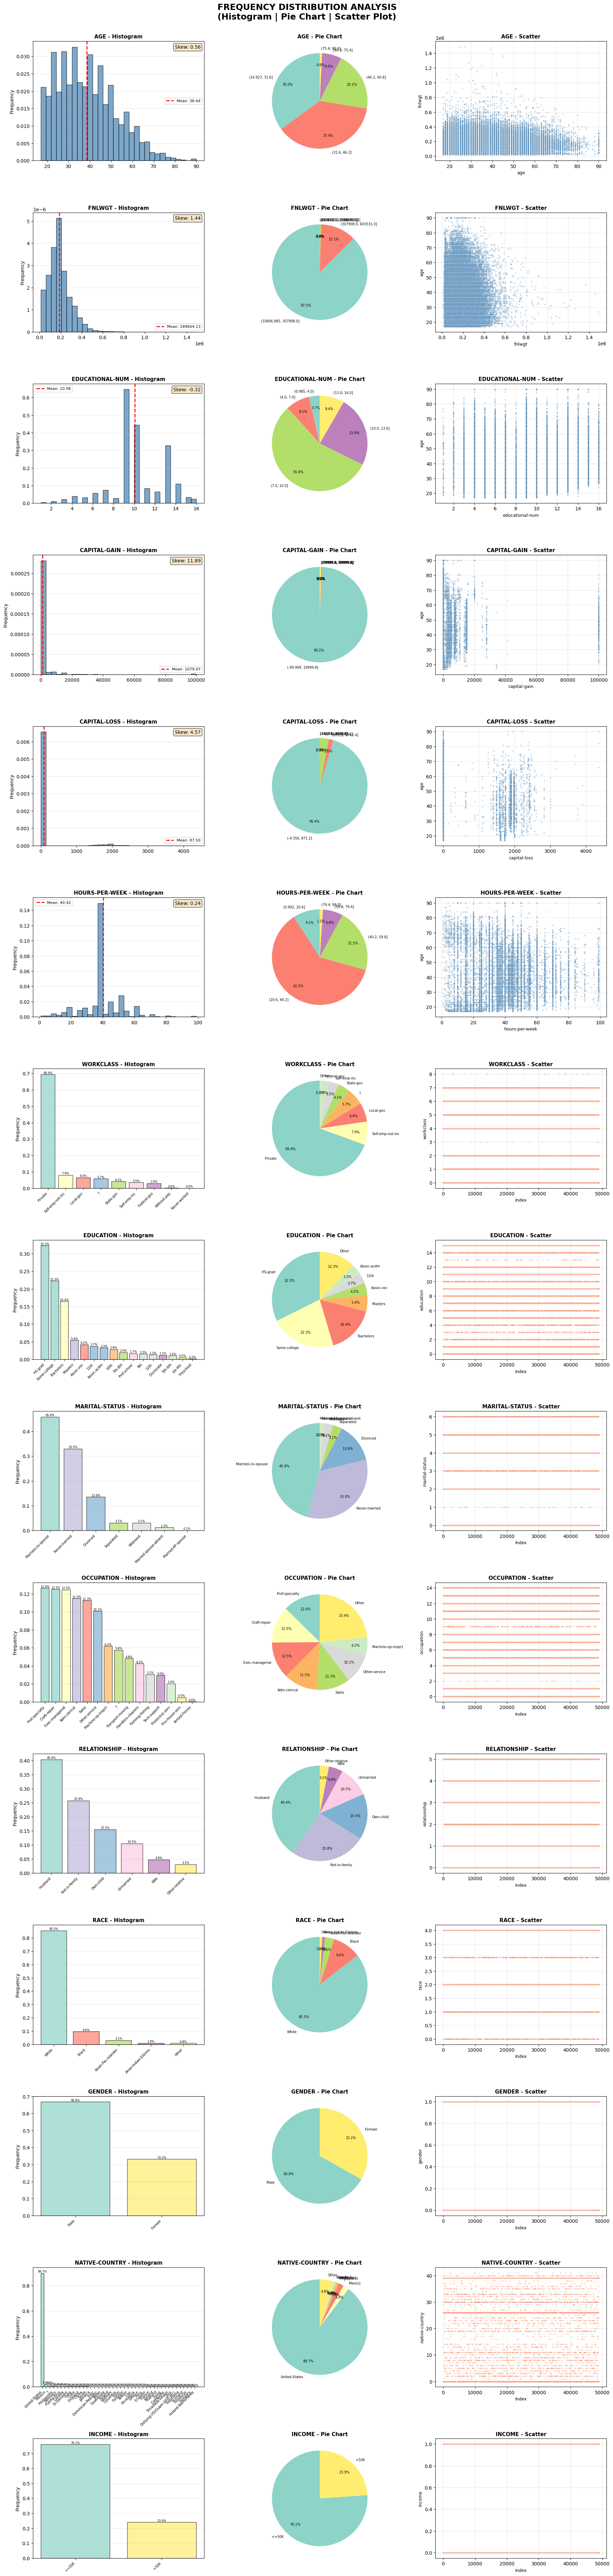

In [38]:
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
all_cols = numerical_cols + categorical_cols

n_features = len(all_cols)
fig, axes = plt.subplots(n_features, 3, figsize=(18, 5*n_features))
fig.suptitle('FREQUENCY DISTRIBUTION ANALYSIS\n(Histogram | Pie Chart | Scatter Plot)', 
             fontsize=18, fontweight='bold', y=1.001)

for row_idx, col in enumerate(all_cols):
    is_numerical = col in numerical_cols
    
    ax1 = axes[row_idx, 0]
    if is_numerical:
        counts, bins, patches = ax1.hist(df[col], bins=30, edgecolor='black', color='steelblue', alpha=0.7, density=True)
        skewness = skew(df[col].dropna())
        ax1.text(0.98, 0.97, f'Skew: {skewness:.2f}', transform=ax1.transAxes,
                ha='right', va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
        mean_val = df[col].mean()
        ax1.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
        ax1.legend(fontsize=8)
    else:
        value_counts = df[col].value_counts()
        normalized_counts = value_counts / value_counts.sum()
        colors_palette = plt.cm.Set3(np.linspace(0, 1, len(value_counts)))
        ax1.bar(range(len(value_counts)), normalized_counts.values, color=colors_palette, edgecolor='black', alpha=0.7)
        ax1.set_xticks(range(len(value_counts)))
        ax1.set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=7)
        for i, v in enumerate(normalized_counts.values):
            ax1.text(i, v, f'{v*100:.1f}%', ha='center', va='bottom', fontsize=6)
    ax1.set_title(f'{col.upper()} - Histogram', fontweight='bold', fontsize=11)
    ax1.set_ylabel('Frequency')
    ax1.grid(axis='y', alpha=0.3)
    
    ax2 = axes[row_idx, 1]
    if is_numerical:
        bins_pie = pd.cut(df[col], bins=5)
        value_counts_pie = bins_pie.value_counts().sort_index()
        labels_pie = [str(x) for x in value_counts_pie.index]
    else:
        value_counts_pie = df[col].value_counts()
        if len(value_counts_pie) > 8:
            top_values = value_counts_pie.head(7)
            top_values['Other'] = value_counts_pie.iloc[7:].sum()
            value_counts_pie = top_values
        labels_pie = value_counts_pie.index.tolist()
    
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(value_counts_pie)))
    wedges, texts, autotexts = ax2.pie(value_counts_pie.values, labels=labels_pie, autopct='%1.1f%%',
                                        colors=colors_pie, startangle=90, pctdistance=0.75)
    for autotext in autotexts:
        autotext.set_fontsize(7)
    for text in texts:
        text.set_fontsize(7)
    ax2.set_title(f'{col.upper()} - Pie Chart', fontweight='bold', fontsize=11)
    
    ax3 = axes[row_idx, 2]
    if is_numerical and len(numerical_cols) > 1:
        other_num = [c for c in numerical_cols if c != col]
        y_col = other_num[0] if other_num else col
        ax3.scatter(df[col], df[y_col], alpha=0.3, s=10, c='steelblue', edgecolors='white', linewidth=0.3)
        ax3.set_xlabel(col, fontsize=9)
        ax3.set_ylabel(y_col, fontsize=9)
    else:
        if is_numerical:
            ax3.scatter(range(len(df)), df[col], alpha=0.3, s=10, c='steelblue', edgecolors='white', linewidth=0.3)
        else:
            ax3.scatter(range(len(df)), df[col].astype('category').cat.codes, alpha=0.3, s=10, c='coral', edgecolors='white', linewidth=0.3)
        ax3.set_xlabel('Index', fontsize=9)
        ax3.set_ylabel(col, fontsize=9)
    ax3.set_title(f'{col.upper()} - Scatter', fontweight='bold', fontsize=11)
    ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

- -0.5 to 0.5: Fairly symmetrical 

- -1 to -0.5 or 0.5 to 1: Moderately skewed.

- Less than -1 or Greater than 1: Highly skewed to solve use `Log Transformation`.

## 5. Data Cleaning

workclass             2799 replaced with 'Private'
occupation            2809 replaced with 'Prof-specialty'
native-country         857 replaced with 'United-States'
          Duplicates value: 53
Duplicates value remaining: 0
   Original records: 48,842
   After cleaning  : 48,789
   Records deleted : 53 
   Records kept    : 48,789 
   Missing values  : 0
   Data Quality    : Bad


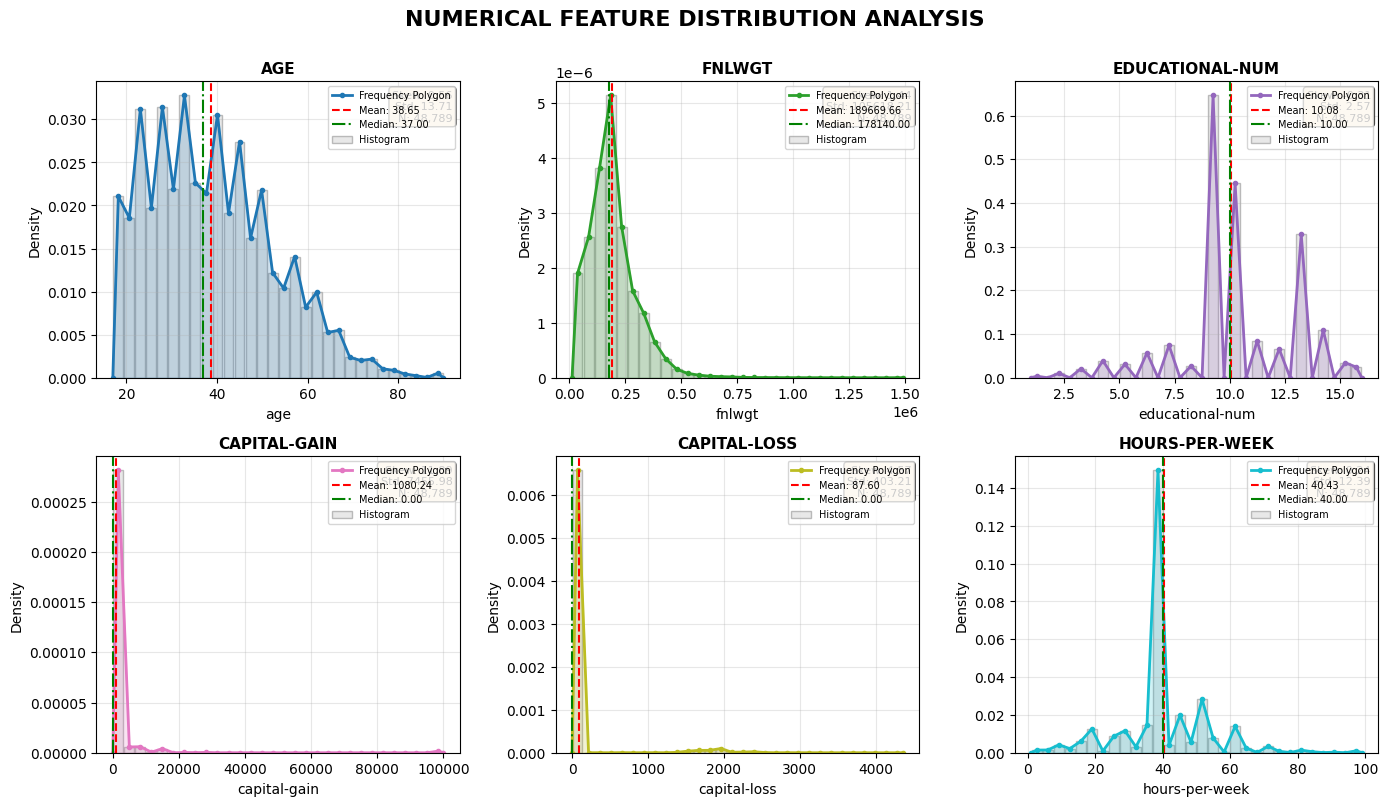

(<Figure size 1400x800 with 6 Axes>,
 array([<Axes: title={'center': 'AGE'}, xlabel='age', ylabel='Density'>,
        <Axes: title={'center': 'FNLWGT'}, xlabel='fnlwgt', ylabel='Density'>,
        <Axes: title={'center': 'EDUCATIONAL-NUM'}, xlabel='educational-num', ylabel='Density'>,
        <Axes: title={'center': 'CAPITAL-GAIN'}, xlabel='capital-gain', ylabel='Density'>,
        <Axes: title={'center': 'CAPITAL-LOSS'}, xlabel='capital-loss', ylabel='Density'>,
        <Axes: title={'center': 'HOURS-PER-WEEK'}, xlabel='hours-per-week', ylabel='Density'>],
       dtype=object))

In [39]:
df_clean = df.copy()

for col in df_clean.columns:
    if (df_clean[col] == '?').sum() > 0:
        bad_count = (df_clean[col] == '?').sum()
        mode_value = df_clean[df_clean[col] != '?'][col].mode()
        if len(mode_value) > 0:
            replacement_value = mode_value[0]
            df_clean[col] = df_clean[col].replace('?', replacement_value)
            print(f"{col:<20} {bad_count:>5} replaced with '{replacement_value}'")

df_clean['income'] = df_clean['income'].map({'<=50K': 0, '>50K': 1})

duplicates_before = df_clean.duplicated().sum()

if duplicates_before > 0:
    status = "Bad"
    df_clean = df_clean.drop_duplicates()
    duplicates_after = df_clean.duplicated().sum()
    print(f"          Duplicates value: {duplicates_before}")
    print(f"Duplicates value remaining: {duplicates_after}")
else:
    status = "Good"


print(f"   Original records: {len(df):,}")
print(f"   After cleaning  : {len(df_clean):,}")
print(f"   Records deleted : {len(df) - len(df_clean):,} ")
print(f"   Records kept    : {len(df_clean):,} ")
print(f"   Missing values  : {df_clean.isnull().sum().sum()}")
print(f"   Data Quality    : {status}")
df = df_clean

plot_frequency_polygon(df, columns=numerical_cols, bins=30, show_histogram=True, density=True, 
                       show_stats=True, figsize=(14, 8), title='NUMERICAL FEATURE DISTRIBUTION ANALYSIS')

## 6. Feature Analysis & Engineering

- hours-per-week spike at 40 hours
- fnlwgt weak predictive power

46.7% of records are exactly at 40h per week
Full-time (>=40h)     : 37,115 (76.1%)
Part-time (<40h)      : 11,674 (23.9%)


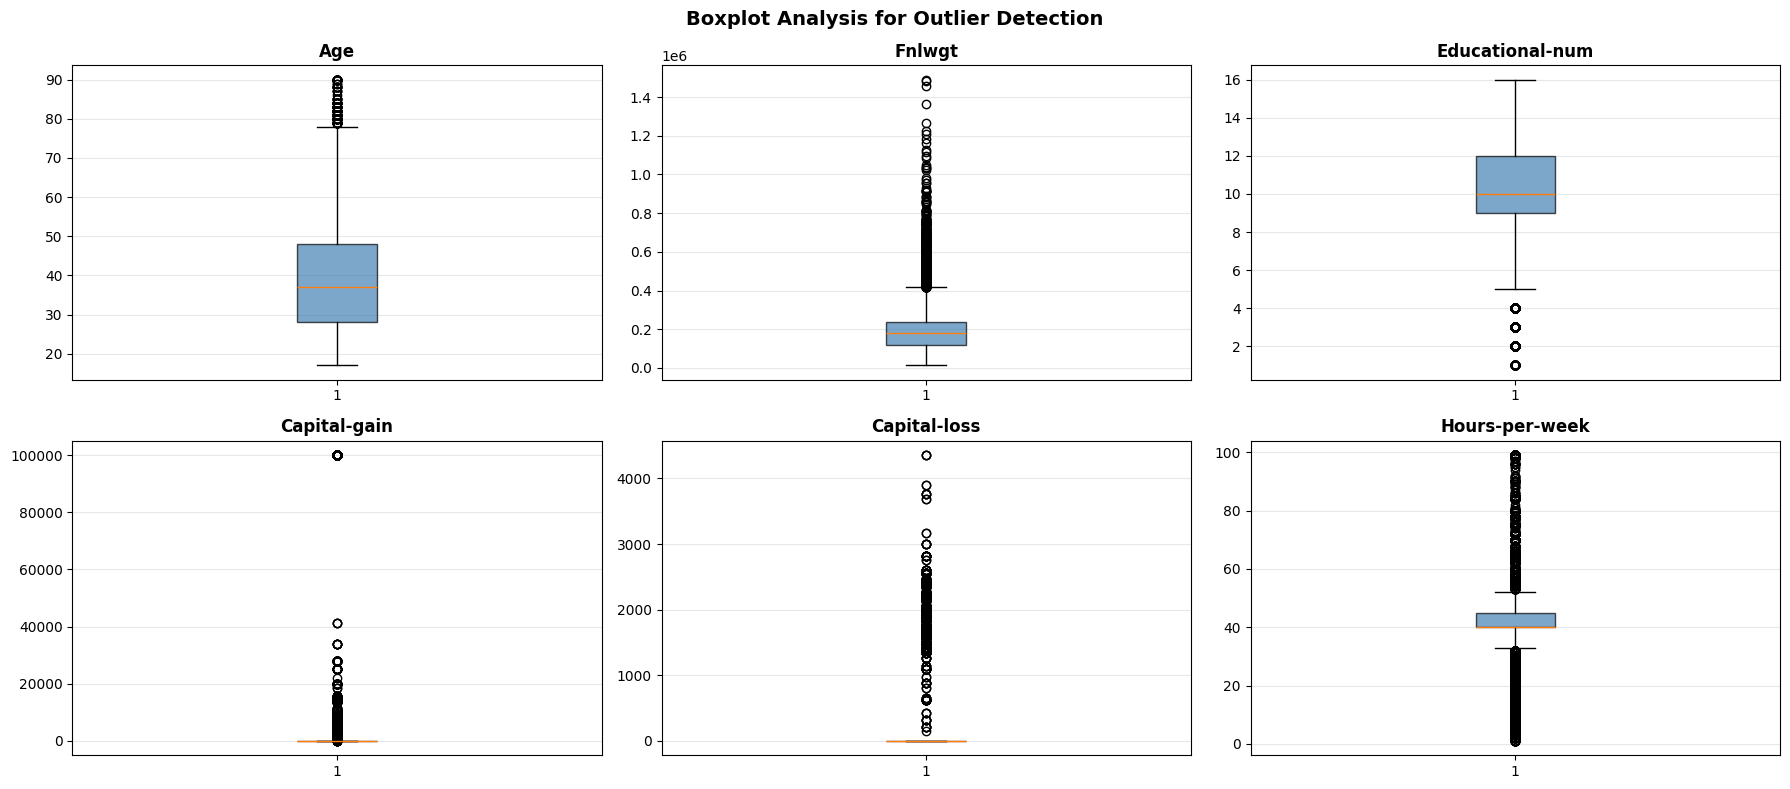

In [48]:
hours_40_count = (df_clean['hours-per-week'] == 40).sum()
hours_40_pct = (hours_40_count / len(df_clean)) * 100
print(f"{hours_40_pct:.1f}% of records are exactly at 40h per week")

df_clean['is_full_time'] = (df_clean['hours-per-week'] >= 40).astype(int)
full_time = (df_clean['is_full_time'] == 1).sum()
part_time = (df_clean['is_full_time'] == 0).sum()
print(f"Full-time (>=40h)     : {full_time:,} ({full_time/len(df_clean)*100:.1f}%)")
print(f"Part-time (<40h)      : {part_time:,} ({part_time/len(df_clean)*100:.1f}%)")

plot_boxplots(df, numerical_cols=numerical_cols, cols_per_row=3)


## 7. Unique value on Categorical features

**************************************************
Unique value in 8 categorical features
**************************************************
Income :[0 1]
Age :[25 38 28 44 18 34 29 63 24 55 65 36 26 58 48 43 20 37 40 72 45 22 23 54
 32 46 56 17 39 52 21 42 33 30 47 41 19 69 50 31 59 49 51 27 57 61 64 79
 73 53 77 80 62 35 68 66 75 60 67 71 70 90 81 74 78 82 83 85 76 84 89 88
 87 86]
Workclass :['Private' 'Local-gov' 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
workclass: 8
education: 16
marital-status: 7
occupation: 14
relationship: 6
race: 5
gender: 2
native-country: 41
Data Shape: 48,789 × 16 columns


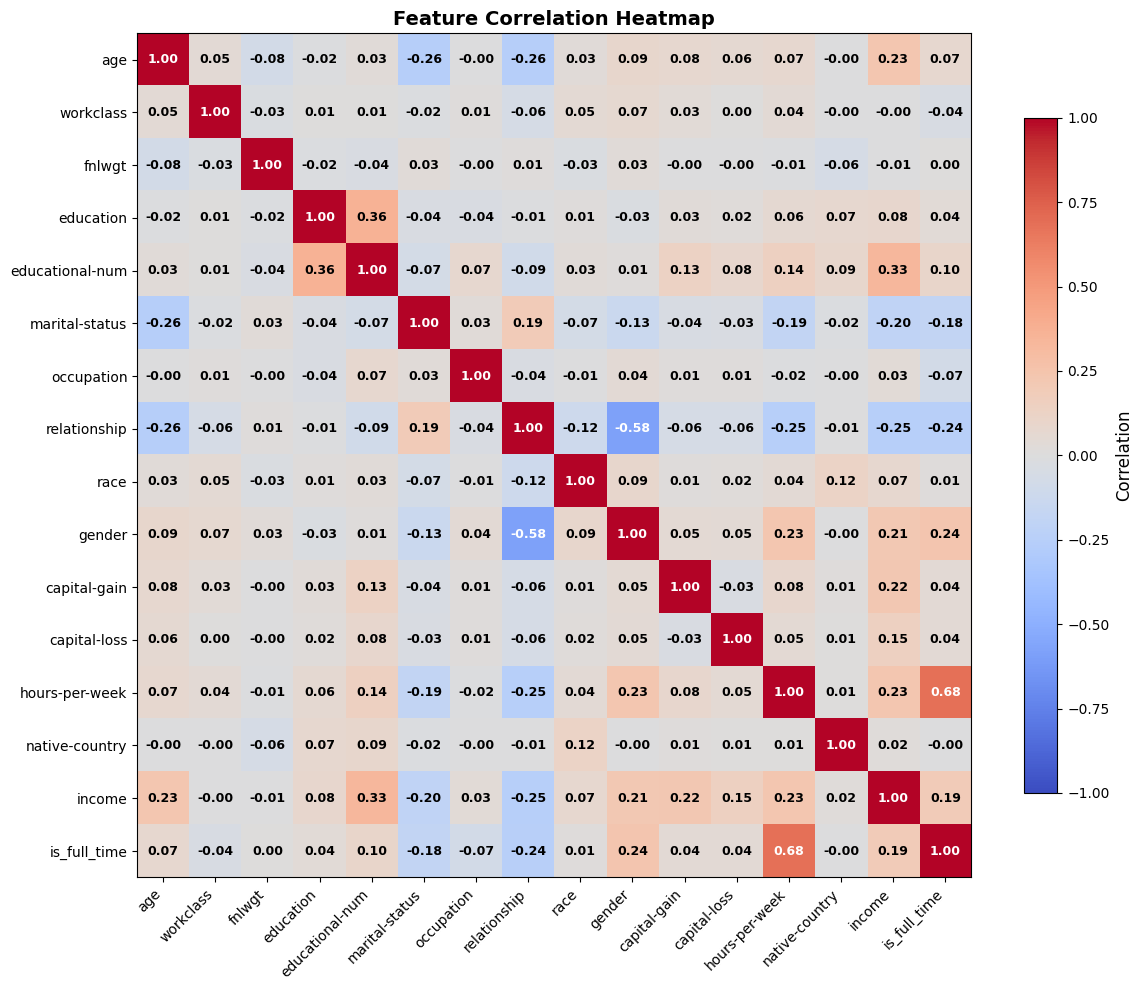

In [49]:
df_encoded = df_clean.copy()
label_encoders = {}

categorical_col = df_clean.select_dtypes(include=['object']).columns.tolist()
categorical_to_encode = [col for col in categorical_col if col != 'income']

print("*" * 50)
print(f"Unique value in {len(categorical_to_encode)} categorical features")
print("*" * 50)

print(f"Income :{df_clean['income'].unique()}")
print(f"Age :{df_clean['age'].unique()}")
print(f"Workclass :{df_clean['workclass'].unique()}")
for col in categorical_to_encode:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)}")
print(f"Data Shape: {df_encoded.shape[0]:,} × {df_encoded.shape[1]} columns")

plot_correlation_heatmap(df_encoded, numerical_cols=df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist())

## 8. Train, Test and Split 

> Target variable `income` we give other value it pradict that Person make above or below 50K

In [ ]:
X = df_encoded.drop(['income'], axis=1)
y = df_encoded['income']

print(f"Features: {len(X.columns)}")
print(f"Target samples: {len(y)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3327, stratify=y
)

Features: 15
Target samples: 48789


## 9. Selective Feature Scaling

In [50]:
scale_features = ['age', 'hours-per-week', 'is_full_time']

print(f"Standard Scaler to {len(scale_features)} features:")
print(f"Features: {scale_features}")

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_features] = scaler.fit_transform(X_train[scale_features])
X_test_scaled[scale_features] = scaler.transform(X_test[scale_features])

print(f"Scaling data  Validation:")
for feat in scale_features:
    mean_val = X_train_scaled[feat].mean()
    std_val = X_train_scaled[feat].std()
    print(f"   {feat:<20} mean={mean_val:>8.6f}, std={std_val:>8.6f}")

Standard Scaler to 3 features:
Features: ['age', 'hours-per-week', 'is_full_time']
Scaling data  Validation:
   age                  mean=-0.000000, std=1.000013
   hours-per-week       mean=-0.000000, std=1.000013
   is_full_time         mean=0.000000, std=1.000013


## 10. Data Visualization

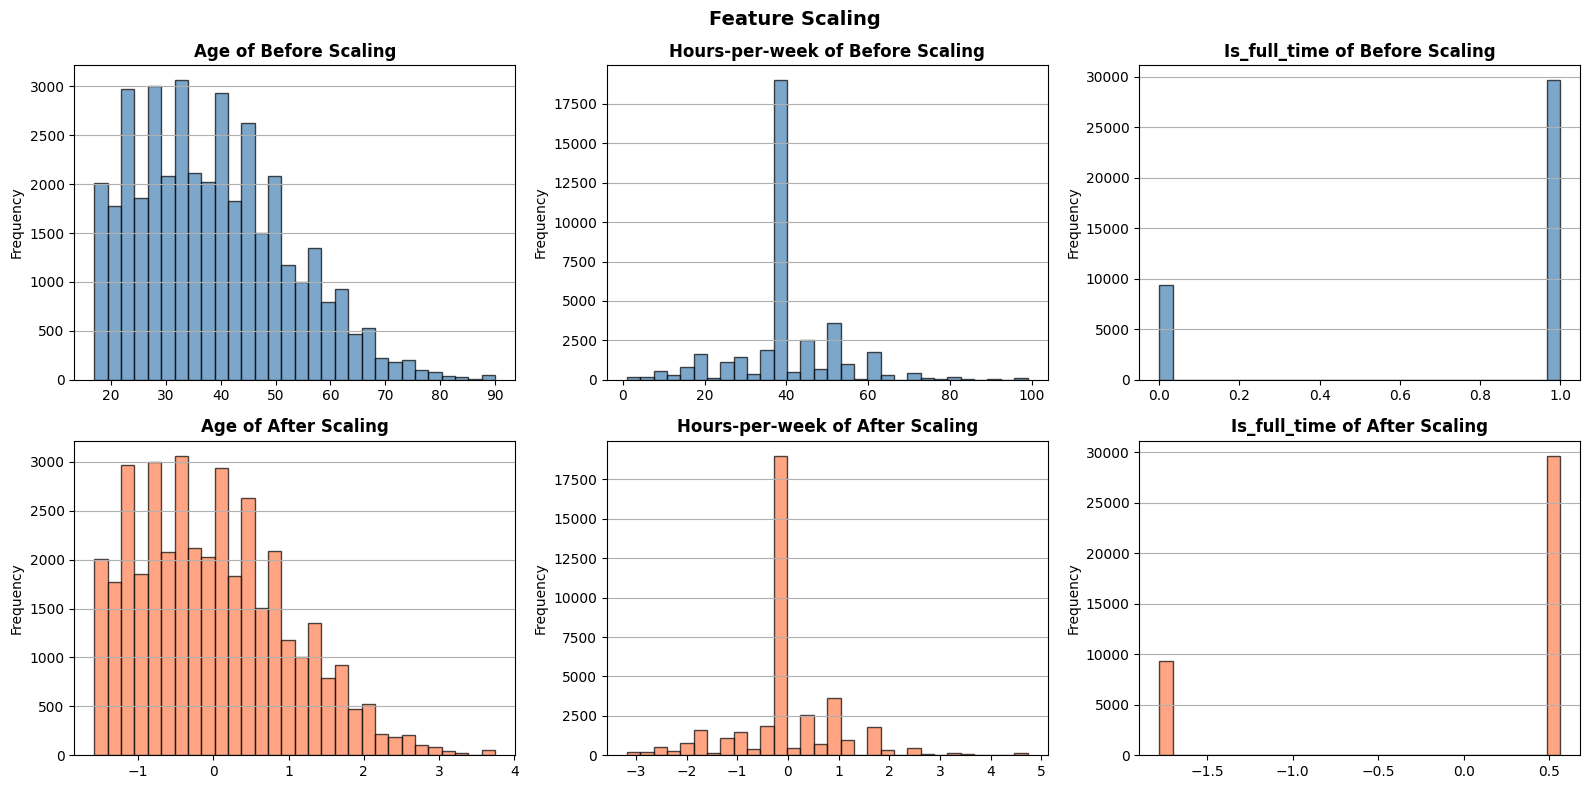

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('Feature Scaling', fontsize=14, fontweight='bold')

for idx, col in enumerate(scale_features):
    axes[0, idx].hist(X_train[col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, idx].set_title(f'{col.capitalize()} of Before Scaling', fontweight='bold')
    axes[0, idx].set_ylabel('Frequency')
    axes[0, idx].grid(axis='y')
    
    axes[1, idx].hist(X_train_scaled[col], bins=30, color='coral', edgecolor='black', alpha=0.7)
    axes[1, idx].set_title(f'{col.capitalize()} of After Scaling', fontweight='bold')
    axes[1, idx].set_ylabel('Frequency')
    axes[1, idx].grid(axis='y')

plt.tight_layout()
plt.show()

- Verify that scaling centers features around mean=0 with std=1
- Improves model convergence and feature importance interpretation

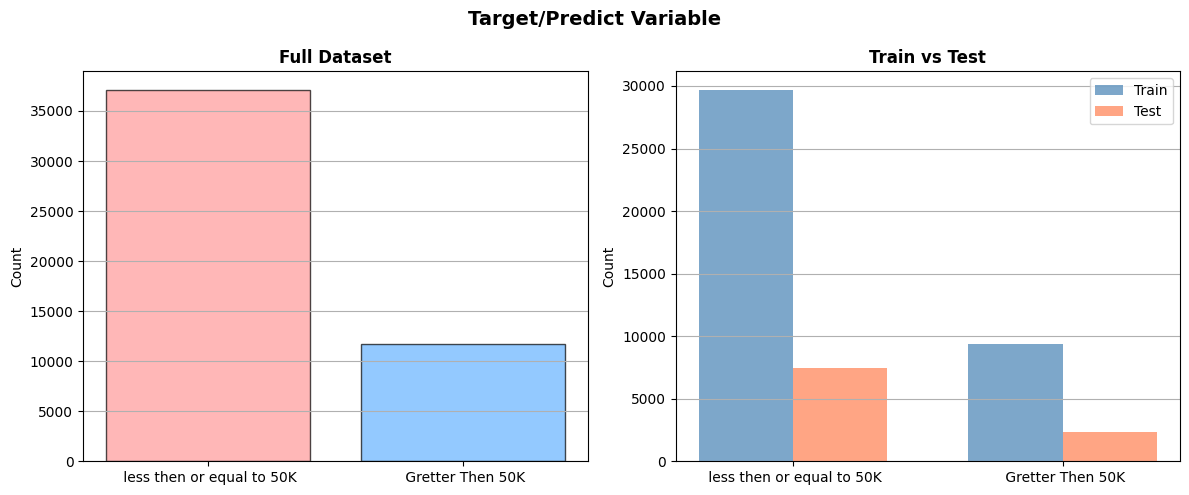

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Target/Predict Variable', fontsize=14, fontweight='bold')

income_counts = df_encoded['income'].value_counts()
axes[0].bar([' less then or equal to 50K', ' Gretter Then 50K'], [income_counts[0], income_counts[1]], color=['#ff9999', '#66b3ff'], edgecolor='black', alpha=0.7)
axes[0].set_title('Full Dataset', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y')

train_income = y_train.value_counts()
test_income = y_test.value_counts()
x = np.arange(2)
width = 0.35
axes[1].bar(x - width/2, [train_income[0], train_income[1]], width, label='Train', color='steelblue', alpha=0.7)
axes[1].bar(x + width/2, [test_income[0], test_income[1]], width, label='Test', color='coral', alpha=0.7)
axes[1].set_title('Train vs Test', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([' less then or equal to 50K', ' Gretter Then 50K'])
axes[1].set_ylabel('Count')
axes[1].legend()
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

- Verify stratified splitting maintains class proportions
- Ensures balanced evaluation across train and test sets

## 11. Export Datasets

In [46]:
notebook_dir = os.path.dirname(os.path.abspath(''))
project_root = os.path.dirname(notebook_dir) if 'notebook' in notebook_dir else os.getcwd()
data_dir = os.path.join(project_root, "data")
os.makedirs(data_dir, exist_ok=True)

print(f"Output Path           : {data_dir}")

try:
    X_train_scaled.to_csv(os.path.join(data_dir, 'X_train_scaled.csv'), index=False)
    y_train.to_csv(os.path.join(data_dir, 'y_train.csv'), index=False, header=['income'])
    
    X_test_scaled.to_csv(os.path.join(data_dir, 'X_test_scaled.csv'), index=False)
    y_test.to_csv(os.path.join(data_dir, 'y_test.csv'), index=False, header=['income'])
    
    print(f"X_train_scaled.csv    : {X_train_scaled.shape}")
    print(f"y_train.csv           : {y_train.shape}")
    print(f"X_test_scaled.csv     : {X_test_scaled.shape}")
    print(f"y_test.csv            : {y_test.shape}")
    
except Exception as e:
    print(f"Error saving datasets: {e}")

Output Path           : e:\adult-income-analysis\notebook\data
X_train_scaled.csv    : (39031, 15)
y_train.csv           : (39031,)
X_test_scaled.csv     : (9758, 15)
y_test.csv            : (9758,)


## 12. Summary of Prossess Datasets

In [47]:
print(f"Train set :{X_train_scaled.shape[0]:,} samples")
print(f"Test set  :{X_test_scaled.shape[0]:,} samples")
print(f"Ratio     :{80:.0f}% / {20:.0f}%")

Train set :39,031 samples
Test set  :9,758 samples
Ratio     :80% / 20%
